## Generate wn_gold_all.tsv file

In [1]:
import rltk
import csv
import matplotlib.pyplot as plt

In [2]:
def load_file(filename):
    with open(filename, "r",encoding="UTF-8") as f:
        """
        load data
        token is split by "\t"
        """
        head = f.readline().strip().split("\t")
        lines = []

        for line in f:
            lines.append(line.strip().split("\t"))
    return head, lines
head, lines = load_file("kgtk_wordnet.tsv")

In [3]:
# what does the head look like
head

['node1',
 'relation',
 'node2',
 'node1;label',
 'node2;label',
 'relation;label',
 'relation;dimension',
 'source',
 'sentence']

In [4]:
def multiple_labels(node_labels,node_noid):
    """
    Obtain label whose leven distance is most close to the node id
    """
    node_res=[float("inf"),""]
    for label in node_labels.split("|"):
        # remove ""
        label = label.replace('"',"").replace("\\'","'")
        dis = rltk.levenshtein_distance(node_noid, label)
        temp = [dis,label]
        
        if temp < node_res:
            node_res  = temp
            
    return node_res[1]

In [7]:
def generate_gold_file(lines):
    wn_gold_all = []
    i = 0
    for line in lines:
        #change column to node1;label, relation, node2;label, node1, node2
        node1_id = line[0]
        relation = line[1]
        node2_id = line[2]
        node1_labels = line[3]
        node2_labels = line[4]
        # modeify the node labels, check with leve distance
        
        #node1_noid = node1.split(":")[1].split(".")[0]
        #node2_noid = node2.split(":")[1].split(".")[0]

        node1_label = multiple_labels(node1_labels,node1_id)
        node2_label = multiple_labels(node2_labels,node2_id)

        wn_gold_all.append([node1_label, relation, node2_label, node1_id, node2_id])
        print(f"\r {i}/{len(lines)}", end="")
        i += 1
        
    return wn_gold_all

In [8]:
wn_gold_all = generate_gold_file(lines)
# example of new dataset
wn_gold_all[0]

 111275/111276

['physical entity',
 '/r/IsA',
 'entity',
 'wn:physical_entity.n.01',
 'wn:entity.n.01']

In [9]:
# new head
new_head = ['node1;label','relation','node2;label','node1','node2']
# write in to file
with open("wn_gold_all.tsv", "w", newline='') as f:
    writer = csv.writer(f, delimiter='\t')
    writer.writerow(new_head)
    writer.writerows(wn_gold_all)

In [10]:
wn_gold_all[:10]

[['physical entity',
  '/r/IsA',
  'entity',
  'wn:physical_entity.n.01',
  'wn:entity.n.01'],
 ['abstraction', '/r/IsA', 'entity', 'wn:abstraction.n.06', 'wn:entity.n.01'],
 ['thing',
  '/r/IsA',
  'physical entity',
  'wn:thing.n.12',
  'wn:physical_entity.n.01'],
 ['object',
  '/r/IsA',
  'physical entity',
  'wn:object.n.01',
  'wn:physical_entity.n.01'],
 ['whole', '/r/IsA', 'object', 'wn:whole.n.02', 'wn:object.n.01'],
 ['congener', '/r/IsA', 'whole', 'wn:congener.n.03', 'wn:whole.n.02'],
 ['living thing', '/r/IsA', 'whole', 'wn:living_thing.n.01', 'wn:whole.n.02'],
 ['organism',
  '/r/IsA',
  'living thing',
  'wn:organism.n.01',
  'wn:living_thing.n.01'],
 ['benthos', '/r/IsA', 'organism', 'wn:benthos.n.02', 'wn:organism.n.01'],
 ['dwarf', '/r/IsA', 'organism', 'wn:dwarf.n.03', 'wn:organism.n.01']]

## statistics calculation

In [59]:
def distribution(wn_gold_all):
    # obtain the dsitribution of each label
    # output: {label1-> str: num->integer}
    distri = dict()
    for line in wn_gold_all:
        node1_label = line[0]
        node2_label = line[2]
        node1_id = line[3]
        node2_id = line[4]
        temp1 = distri.get(node1_label,set())
        temp1.add(node1_id)
        temp2 = distri.get(node2_label,set())
        temp2.add(node2_id)
        distri[node1_label] = temp1
        distri[node2_label] = temp2
    
    for item in distri:
        distri[item] = len(distri[item])
    return distri

mean ambiguity of label: 1.3192577820168212 size of records: 111276


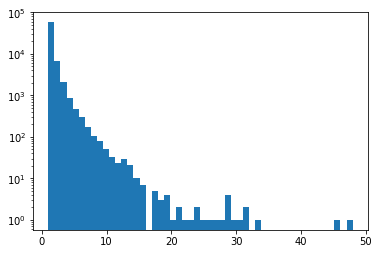

In [60]:
distri = distribution(wn_gold_all)
plt.hist(distri.values(),log=True,bins=50)
print("mean ambiguity of label:", sum(distri.values())/len(distri), "size of records:", len(wn_gold_all))

In [61]:
for item in distri:
    if distri[item] > 20:
        print(item)

play
break
cut
drive
pass
draw
catch
check
call
turn
point
run
beat
carry
fall
charge
cover
line
head
give
make


## Random Pick

In [62]:
import random

In [63]:
# random pick 200 records
wn_gold_200 = random.choices(wn_gold_all, k=200)

In [64]:
wn_gold_200

[['bib', '/r/PartOf', 'apron', 'wn:bib.n.01', 'wn:apron.n.01'],
 ['power',
  '/r/IsA',
  'physical phenomenon',
  'wn:power.n.02',
  'wn:physical_phenomenon.n.01'],
 ['Euphausia pacifica',
  '/r/IsA',
  'krill',
  'wn:euphausia_pacifica.n.01',
  'wn:krill.n.01'],
 ['dance', '/r/IsA', 'move', 'wn:dance.v.01', 'wn:move.v.03'],
 ['iron-grey', '/r/IsA', 'grayness', 'wn:iron-grey.n.01', 'wn:gray.n.01'],
 ['hip boot', '/r/IsA', 'boot', 'wn:hip_boot.n.01', 'wn:boot.n.01'],
 ['susurrate', '/r/IsA', 'murmur', 'wn:susurrate.v.01', 'wn:murmur.v.01'],
 ['strawflower',
  '/r/IsA',
  'bellwort',
  'wn:strawflower.n.01',
  'wn:bellwort.n.01'],
 ['blackwood', '/r/IsA', 'wood', 'wn:blackwood.n.01', 'wn:wood.n.01'],
 ['throw', '/r/IsA', 'propulsion', 'wn:throw.n.01', 'wn:propulsion.n.02'],
 ['offer', '/r/IsA', 'threaten', 'wn:offer.v.13', 'wn:threaten.v.02'],
 ['Coleonyx',
  '/r/IsA',
  'reptile genus',
  'wn:coleonyx.n.01',
  'wn:reptile_genus.n.01'],
 ['hospitalization',
  '/r/IsA',
  'condition',
  '

In [65]:
new_head = ['node1;label','relation','node2;label','node1','node2']
# write in to file 200 records
with open("wn_gold_200.tsv", "w", newline='') as f:
    writer = csv.writer(f, delimiter='\t')
    writer.writerow(new_head)
    writer.writerows(wn_gold_200)

## Get synsets

In [66]:
from nltk.corpus import wordnet as wn

In [67]:
import re
from itertools import combinations

In [68]:
all_synsets = list(wn.all_synsets())

In [69]:
# obtain the regex structure of word combination
regex_dis = dict()
for synset in all_synsets:
    name = synset.name().split(".")[0]
    regex_temple = ""
    for w in name:
        if not regex_temple:
            if w.isalpha():
                regex_temple += "x"
            else:
                regex_temple += w
                
            continue
        
        if w.isalpha() and (not regex_temple[-1].isalpha()):
            regex_temple += "x"
            
        elif not w.isalpha():
            regex_temple += w
    #if regex_temple == "x_x_x_x'x_x":
    #   print(name)
    regex_dis[regex_temple] = name

In [70]:
regex_dis

{'x': 'deflagrate',
 'x-x': 'spread-eagle',
 'x-x-x': 'nickel-and-dime',
 'x-x-x-x': 'how-do-you-do',
 'x_x': 'fog_up',
 'x_x_x': 'come_in_for',
 'x_x_x_x': 'go_a_long_way',
 'x_x_x_x_x': 'fly_in_the_face_of',
 'x-x_x': 'triple-crown_season',
 'x2x_x': 'y2k_compliant',
 'x_x_x-x': 'go_off_half-cocked',
 "x_x'x": "lag_b'omer",
 "x'x-x": "dhu'l-hijja",
 '': '',
 "x'x": "entr'acte",
 "x_x_x'x_x": "talk_through_one's_hat",
 'x_x_x_x_x_x': 'take_the_bull_by_the_horns',
 "x_x'x_x_x": "keep_one's_eyes_peeled",
 "x_x'x_x": "hold_one's_own",
 "x'x_x": "saint's_day",
 'x-x-x_x': 'balance-of-payments_problem',
 "x-x'x_x": "wine-maker's_yeast",
 'x_x-x_x': 'growth_hormone-releasing_factor',
 'x-x_x_x_x': 'object-oriented_database_management_system',
 'x-x_x_x': 'round-trip_light_time',
 'x-x-x_x_x': 'track-to-track_seek_time',
 'x_x_x_x_x_x_x': 'association_for_the_advancement_of_retired_persons',
 'x-x_x_x_x_x_x_x': 'blood-oxygenation_level_dependent_functional_magnetic_resonance_imaging',
 'x_x-

In [71]:
def place_ones(size, count):
    for positions in combinations(range(size), count):
        p = [0] * size

        for i in positions:
            p[i] = 1

        yield p
        
# permutations of list n without repitation
def permu(n):
    comb = []
    for i in range(n+1):
        comb += place_ones(n,i)
        
    return comb

def replace_str(string, replace_w, idx):
    # replace whitespace to _ or -
    return string[:idx] + replace_w +string[idx+1:]

In [72]:
permu(4)

[[0, 0, 0, 0],
 [1, 0, 0, 0],
 [0, 1, 0, 0],
 [0, 0, 1, 0],
 [0, 0, 0, 1],
 [1, 1, 0, 0],
 [1, 0, 1, 0],
 [1, 0, 0, 1],
 [0, 1, 1, 0],
 [0, 1, 0, 1],
 [0, 0, 1, 1],
 [1, 1, 1, 0],
 [1, 1, 0, 1],
 [1, 0, 1, 1],
 [0, 1, 1, 1],
 [1, 1, 1, 1]]

In [73]:
def transfer_words(label):
    idx_list = [x for x, v in enumerate(label) if v == ' ']
    
    if not idx_list:
        #no whitespace in words
        yield label
    else:
        # whitespace in words
        combs = permu(len(idx_list))
        for comb in combs:
            for idx, status, in zip(idx_list, comb):
                if status:
                    label = replace_str(label, "-", idx)
                else:
                    label = replace_str(label, "_", idx)
            yield label
            
def generate_synsets(labels):
    for label in labels:
        synsets = list(wn.synsets(label))
        
        if synsets:
            return synsets, label
        
    return [], label

def generate_candidates(label):
    candidates,_ = generate_synsets(transfer_words(label))
    return candidates

In [74]:
# example of word combination
generate_candidates("far cry")

[Synset('far_cry.n.01'), Synset('far_cry.n.02')]

In [75]:
# example of word combination
generate_candidates("ladder back")

[Synset('ladder-back.n.01'), Synset('ladder-back.n.02')]

## Random Baseline

In [76]:
def MRS(wn_gold):
    wn_predict = []
    for line in wn_gold:
        label1  = line[0]
        label2 = line[2]
        relationship = line[1]
        
        candidates1 = generate_candidates(label1)
        candidates2 = generate_candidates(label2)
        
        if candidates1:
            node1_id = random.choice(candidates1)
        else:
            print(label1)
            #_ = label1
            node1_id = ""
        
        if candidates2:
            node2_id = random.choice(candidates2)
        else:
            print(label2)
            #_ = label2
            node2_id = ""
        
        #print(node2_id)
        wn_predict.append([label1, relationship, label2, node1_id, node2_id])
        
    return wn_predict

In [77]:
wn_predict_200 = MRS(wn_gold_200)
wn_predict_200

[['bib', '/r/PartOf', 'apron', Synset('bib.n.01'), Synset('proscenium.n.01')],
 ['power',
  '/r/IsA',
  'physical phenomenon',
  Synset('might.n.01'),
  Synset('physical_phenomenon.n.01')],
 ['Euphausia pacifica',
  '/r/IsA',
  'krill',
  Synset('euphausia_pacifica.n.01'),
  Synset('krill.n.01')],
 ['dance', '/r/IsA', 'move', Synset('dance.n.02'), Synset('move.v.13')],
 ['iron-grey',
  '/r/IsA',
  'grayness',
  Synset('iron-grey.n.01'),
  Synset('gray.n.01')],
 ['hip boot', '/r/IsA', 'boot', Synset('hip_boot.n.01'), Synset('boot.v.01')],
 ['susurrate',
  '/r/IsA',
  'murmur',
  Synset('susurrate.v.01'),
  Synset('murmur.v.01')],
 ['strawflower',
  '/r/IsA',
  'bellwort',
  Synset('strawflower.n.03'),
  Synset('bellwort.n.01')],
 ['blackwood',
  '/r/IsA',
  'wood',
  Synset('blackwood.n.01'),
  Synset('wood.n.05')],
 ['throw',
  '/r/IsA',
  'propulsion',
  Synset('throw.v.01'),
  Synset('propulsion.n.02')],
 ['offer',
  '/r/IsA',
  'threaten',
  Synset('volunteer.v.02'),
  Synset('threa

In [78]:
def synset2str(syn):
    # transfer synset to str in gold file
    # print(syn), print(type(syn))
    if type(syn) == str:
        return "wn:"
    return "wn:"+ syn.name()

def validation(wn_predict,wn_gold):
    # check accracy of prediction
    # accuracy1: if label is correct, true positive +1
    # accuracy2: iff two labels in one record are correct (record is correct), true positive +1
    correct1 = 0
    correct2 = 0
    for predict, actual in zip(wn_predict, wn_gold):
        #print(predict, actual)
        judge = [synset2str(predict[3]) == actual[3],synset2str(predict[4]) == actual[4]]
        #print(predict[3],actual[3])
        if judge[0]:
            correct1 += 1
            
        if judge[1]:
            correct1 += 1
            
        if all(judge):
            correct2 += 1
            
    return correct1/(len(wn_predict)*2), correct2/len(wn_predict)

def write_prediction(filename, lines):
    # write prediction to file
    new_head = ['node1;label','relation','node2;label','node1','node2']
    # write in to file 200 records
    with open(filename, "w", newline='') as f:
        writer = csv.writer(f, delimiter='\t')
        writer.writerow(new_head)
        for line in lines:
            writer.writerow([line[0],line[1],line[2],synset2str(line[3]),synset2str(line[4])])

In [79]:
write_prediction("wn_MRS_200.tsv", wn_predict_200)
accuracy1, accuracy2 = validation(wn_predict_200,wn_gold_200)
accuracy1, accuracy2

(0.6375, 0.43)

## Frequent Baseline

In [126]:
def MFS(wn_gold):
    wn_predict = []
    for line in wn_gold:
        label1  = line[0]
        label2 = line[2]
        relationship = line[1]
        
        candidates1 = generate_candidates(label1)
        candidates2 = generate_candidates(label2)
        
        if candidates1:
            node1_id = candidates1[0]
        else:
            #print(label1)
            #_ = label1
            node1_id = ""
        
        if candidates2:
            node2_id = candidates2[0]
        else:
            #print(label2)
            #_ = label2
            node2_id = ""
        
        #print(node2_id)
        wn_predict.append([label1, relationship, label2, node1_id, node2_id])
        
    return wn_predict

In [122]:
wn_predict_200 = MFS(wn_gold_200)
wn_predict_200

[['bib', '/r/PartOf', 'apron', Synset('bib.n.01'), Synset('apron.n.01')],
 ['power',
  '/r/IsA',
  'physical phenomenon',
  Synset('power.n.01'),
  Synset('physical_phenomenon.n.01')],
 ['Euphausia pacifica',
  '/r/IsA',
  'krill',
  Synset('euphausia_pacifica.n.01'),
  Synset('krill.n.01')],
 ['dance', '/r/IsA', 'move', Synset('dance.n.01'), Synset('move.n.01')],
 ['iron-grey',
  '/r/IsA',
  'grayness',
  Synset('iron-grey.n.01'),
  Synset('gray.n.01')],
 ['hip boot', '/r/IsA', 'boot', Synset('hip_boot.n.01'), Synset('boot.n.01')],
 ['susurrate',
  '/r/IsA',
  'murmur',
  Synset('susurrate.v.01'),
  Synset('mutter.n.01')],
 ['strawflower',
  '/r/IsA',
  'bellwort',
  Synset('strawflower.n.01'),
  Synset('bellwort.n.01')],
 ['blackwood',
  '/r/IsA',
  'wood',
  Synset('blackwood.n.01'),
  Synset('wood.n.01')],
 ['throw',
  '/r/IsA',
  'propulsion',
  Synset('throw.n.01'),
  Synset('propulsion.n.01')],
 ['offer',
  '/r/IsA',
  'threaten',
  Synset('offer.n.01'),
  Synset('endanger.v.01'

In [82]:
write_prediction("wn_MFS_200.tsv", wn_predict_200)
accuracy1, accuracy2 = validation(wn_predict_200,wn_gold_200)
accuracy1, accuracy2

(0.7, 0.525)

## sentence-transformer-bert

In [83]:
from sentence_transformers import SentenceTransformer

In [84]:
model_STB = SentenceTransformer('roberta-large-nli-stsb-mean-tokens')

In [85]:
# check the relationship

In [86]:
relationships = set()

for line in wn_gold_all:
    relationships.add(line[1])

In [87]:
relationships

{'/r/IsA', '/r/MadeOf', '/r/PartOf'}

In [88]:
word2sentence = {'/r/IsA':"is a", '/r/MadeOf': "is made of",'/r/PartOf':"is part of"}

In [104]:
def line_sentence(line, word2sentence):
    sentence = line[0]+" "+word2sentence[line[1]]+" "+line[2]
    return sentence

def label2sentence2embed(label,embeddings, model):
    temp = []
    if label in embeddings:
        pass
    else:
        candidates = generate_candidates(label)

        for candit in candidates:
            temp.append([candit,model.encode(candit.definition())])
            
        embeddings[label] = temp
            
    return embeddings

def candidates_embeddings(wn_gold, model):
    embeddings = dict()
    i = 0
    for line in wn_gold:
        label1  = line[0]
        label2 = line[2]
        print("\r",i, end="")
        i +=1
        embeddings = label2sentence2embed(label1,embeddings, model)
        embeddings = label2sentence2embed(label2,embeddings, model)
    return embeddings


def STB(wn_gold, model = None, label_embeddings = None, word2sentence = None):
    wn_predict = []
    i = 0
    for line in wn_gold:
        label1 = line[0]
        label2 = line[2]
        sentence=line_sentence(line, word2sentence)
        sent_embedding = model.encode(sentence)

        #obtain the max similar item for label1
        max_item = [0,""]
        if label1 not in label_embeddings:
            node_id1 = ""
        else:
            for candit, embedding in label_embeddings[label1]:
                similar = rltk.cosine_similarity(list(embedding), list(sent_embedding))
                temp = [similar, candit]

                if temp>max_item:
                    max_item = temp

            node_id1 = max_item[-1]
        
        #obtain the max similar item for label2
        max_item = [0,""]
        if label2 not in label_embeddings:
            node_id2 = ""
        else:
            for candit, embedding in label_embeddings[label2]:
                similar = rltk.cosine_similarity(list(embedding), list(sent_embedding))
                temp = [similar, candit]

                if temp>max_item:
                    max_item = temp

            node_id2 = max_item[-1]
        print("\r",i, end="")
        i +=1
                
        wn_predict.append([label1, line[1], label2,node_id1,node_id2])
        
    return wn_predict

In [91]:
label_embeddings = candidates_embeddings(wn_gold_200, model_STB)

 199

In [92]:
wn_predict_200 = STB(wn_gold_200, model = model_STB, label_embeddings = label_embeddings, word2sentence = word2sentence)

 199

In [93]:
write_prediction("wn_STB_200.tsv", wn_predict_200)
accuracy1, accuracy2 = validation(wn_predict_200,wn_gold_200)
accuracy1, accuracy2

(0.7, 0.48)

## sentence-transformer-roberta

In [94]:
model_STR = SentenceTransformer('bert-large-nli-stsb-mean-tokens')

In [95]:
def STR(wn_gold, model = None, label_embeddings = label_embeddings, word2sentence = word2sentence):
    return STB(wn_gold, model = model, label_embeddings = label_embeddings, word2sentence = word2sentence)

In [96]:
label_embeddings = candidates_embeddings(wn_gold_200, model_STR)

 199

In [97]:
wn_predict_200 = STR(wn_gold_200, model = model_STR, label_embeddings = label_embeddings, word2sentence = word2sentence)

 199

In [98]:
write_prediction("wn_STR_200.tsv", wn_predict_200)
accuracy1, accuracy2 = validation(wn_predict_200,wn_gold_200)
accuracy1, accuracy2

(0.715, 0.525)

## WordNet graph

In [99]:
head, lines = load_file("kgtk_conceptnet.tsv")
lines_1k = random.choices(lines, k=1000)

In [100]:
cn_test_1k = generate_gold_file(lines_1k)

 999/1000

In [127]:
cn_predict_1k = MFS(cn_test_1k)
write_prediction("cn_predict_1k.tsv", cn_predict_1k)
cn_predict_1k[0]

['affix', '/r/RelatedTo', 'stem', Synset('affix.n.01'), Synset('root.n.03')]

In [137]:
def no_synset_prob(cn_predict_1k):
    #prob 1: no synset for label
    #prob 2: no synset for record
    count1 = 0
    count2 = 0
    for record in cn_predict_1k:
        judge = [synset2str(record[3]) == "wn:",synset2str(record[4]) == "wn:"]
        
        if judge[0]:
            count1 += 1
            
        if judge[1]:
            count1 += 1
            
        if any(judge):
            count2 += 1
            
    return count1/(2*len(cn_predict_1k)), count2/len(cn_predict_1k)

In [138]:
prob1,prob2 = no_synset_prob(cn_predict_1k)
prob1, prob2

(0.4385, 0.672)

## sentence-transformer-roberta for WordNet

In [107]:
label_embeddings = candidates_embeddings(cn_test_1k, model_STR)

 999409637

In [112]:
relationships = set()

for line in lines:
    relationships.add(line[1])
    
relationships

{'/r/Antonym',
 '/r/AtLocation',
 '/r/CapableOf',
 '/r/Causes',
 '/r/CausesDesire',
 '/r/CreatedBy',
 '/r/DefinedAs',
 '/r/DerivedFrom',
 '/r/Desires',
 '/r/DistinctFrom',
 '/r/Entails',
 '/r/EtymologicallyDerivedFrom',
 '/r/EtymologicallyRelatedTo',
 '/r/FormOf',
 '/r/HasA',
 '/r/HasContext',
 '/r/HasFirstSubevent',
 '/r/HasLastSubevent',
 '/r/HasPrerequisite',
 '/r/HasProperty',
 '/r/HasSubevent',
 '/r/InstanceOf',
 '/r/IsA',
 '/r/LocatedNear',
 '/r/MadeOf',
 '/r/MannerOf',
 '/r/MotivatedByGoal',
 '/r/NotCapableOf',
 '/r/NotDesires',
 '/r/NotHasProperty',
 '/r/PartOf',
 '/r/ReceivesAction',
 '/r/RelatedTo',
 '/r/SimilarTo',
 '/r/SymbolOf',
 '/r/Synonym',
 '/r/UsedFor',
 '/r/dbpedia/capital',
 '/r/dbpedia/field',
 '/r/dbpedia/genre',
 '/r/dbpedia/genus',
 '/r/dbpedia/influencedBy',
 '/r/dbpedia/knownFor',
 '/r/dbpedia/language',
 '/r/dbpedia/leader',
 '/r/dbpedia/occupation',
 '/r/dbpedia/product'}

In [139]:
word2sentence = {'/r/Antonym':"is antonym for", 
                 '/r/AtLocation': "is located at",
                 '/r/CapableOf':"is capable of",
                '/r/Causes':"causes",
                '/r/CausesDesire':"causes the desire of",
                '/r/CreatedBy':"is created by",
                '/r/DefinedAs': " is defined as",
                '/r/DerivedFrom': "is derived from",
                '/r/Desires':"desires",
                '/r/DistinctFrom':"is distinct from",
                "/r/Entails":"entails",
                '/r/EtymologicallyDerivedFrom':"is etymologically derived from",
                '/r/EtymologicallyRelatedTo': "is etymologically related to",
                '/r/FormOf':"is form of",
                '/r/HasA': "has a",
                '/r/HasContext': "has the context of",
                '/r/HasFirstSubevent': "has first subevent, ",
                '/r/HasLastSubevent':"has last subevent, ",
                '/r/HasPrerequisite': "has prerequisite, ",
                '/r/HasProperty': "has property, ",
                '/r/HasSubevent': "has subevent, ",
                '/r/InstanceOf': " is an instance of",
                '/r/IsA': "is a",
                '/r/LocatedNear': "is located nearby",
                '/r/MadeOf': "is made of",
                '/r/MannerOf':"has a manner of",
                '/r/MotivatedByGoal': "is motivated by goal",
                '/r/NotCapableOf': "is not capable of",
                '/r/NotDesires':"does not desire",
                '/r/NotHasProperty':"does not have property, ",
                '/r/PartOf': "is part of",
                '/r/ReceivesAction':"receives the action, ",
                '/r/RelatedTo':"is related to",
                '/r/SimilarTo':"is similar to",
                '/r/SymbolOf':"is a symbol of",
                '/r/Synonym':"is synonym for",
                '/r/UsedFor':"is used for",
                '/r/dbpedia/capital': "is the capital of",
                '/r/dbpedia/field':" is the field of",
                '/r/dbpedia/genre':"has genre,",
                '/r/dbpedia/genus':"has genus, ",
                '/r/dbpedia/influencedBy':"is influenced by",
                '/r/dbpedia/knownFor': "is known for",
                '/r/dbpedia/language':"is the language ",
                '/r/dbpedia/leader':"has the leader, ",
                '/r/dbpedia/occupation':"has the occupation, ",
                '/r/dbpedia/product':"has the product, "}

cn_predict_1k = STR(cn_test_1k, model = model_STR, label_embeddings = label_embeddings, word2sentence = word2sentence)
write_prediction("cn_predict_1k.tsv", cn_predict_1k)
prob1,prob2 = no_synset_prob(cn_predict_1k)
prob1, prob2

 999

(0.439, 0.673)